<a href="https://colab.research.google.com/github/gmortuza/Google-Landmark-Recognition-2020/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Copy dataset & Importing module & defining constant
---



In [ ]:
# Moving dataset from google drive to colab sessions
# The kaggle dataset is huge(~100GB). Copying that amount of data in every session is not feasible. 
# So created a sample data set. 
# Which I updloaded into the drive
from google.colab import drive
drive.mount("/content/drive")
!mkdir data
!mkdir data/train
!cp "/content/drive/My Drive/kaggle_competition/Google_Landmark_Recognition_2020/data.zip" /content/data/train
!unzip /content/data/train/data.zip

In [131]:
#%%
# Importing necessary module
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [83]:
#%%
# Define constant
BATCH_SIZE = 32
IMAGE_SIZE_WITHOUT_CHANNEL= (608, 736)
IMAGE_SIZE_WITH_CHANNEL = (608, 736, 3)
VALIDATION_RATE = 0.2
OUTPUT_CLASS = 73476
BATCH_SIZE = 32 
EPOCH = 10
CHECKPOINT = os.path.join(os.getcwd(),'checkpoint','model.h5')
DATA_DIR = 'data_1/'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_FILE = os.path.join(TRAIN_DIR, 'train.csv')

# Loading training data

In [84]:
train_df = pd.read_csv(TRAIN_FILE)
train_df.landmark_id = train_df.landmark_id.astype(str)
train_df["location"] = os.getcwd() +"/"+ TRAIN_DIR + "/"+train_df.id.str[0]+"/"+train_df.id.str[1]+"/"+train_df.id.str[2]+"/"+train_df.id+".jpg"
train_df = train_df[:1000]
train_df
#train_df = train_df.sample(10000, random_state=10)

,id,landmark_id,location
0,17660ef415d37059,1,/content/data_1/train/1/7/6/17660ef415d37059.jpg
1,92b6290d571448f6,1,/content/data_1/train/9/2/b/92b6290d571448f6.jpg
2,cd41bf948edc0340,1,/content/data_1/train/c/d/4/cd41bf948edc0340.jpg
3,fb09f1e98c6d2f70,1,/content/data_1/train/f/b/0/fb09f1e98c6d2f70.jpg
4,25c9dfc7ea69838d,7,/content/data_1/train/2/5/c/25c9dfc7ea69838d.jpg
...,...,...,...
995,097eb9044f50f8f6,111,/content/data_1/train/0/9/7/097eb9044f50f8f6.jpg
996,12a131a926cd6deb,111,/content/data_1/train/1/2/a/12a131a926cd6deb.jpg
997,8ad0c1ccca45e21c,111,/content/data_1/train/8/a/d/8ad0c1ccca45e21c.jpg
998,8fafc38f0fb824d2,111,/content/data_1/train/8/f/a/8fafc38f0fb824d2.jpg


In [85]:
gen = ImageDataGenerator(rescale=1./255, validation_split=VALIDATION_RATE)
train_generator = gen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="location",
    y_col="landmark_id",
    target_size=IMAGE_SIZE_WITHOUT_CHANNEL,
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset="training",
    colormode="rgb"
)
validation_generator = gen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="location",
    y_col="landmark_id",
    target_size=IMAGE_SIZE_WITHOUT_CHANNEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    subset="validation",
    colormode="rgb"
)

Found 244 validated image filenames belonging to 40 classes.
Found 61 validated image filenames belonging to 40 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 695 invalid image filename(s) in x_col="location". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Base model

In [86]:
def base_model():

  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=IMAGE_SIZE_WITH_CHANNEL))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(.3))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(.3))
  model.add(Dense(40, activation='softmax'))
  return model

In [141]:
def get_callback(reduceLR=True, chkPoint=True, earlyStop=True):
  callbacks = []
  if reduceLR:
    reduceLR = ReduceLROnPlateau(monitor = 'val_accuracy',
                                patience = 2,
                                factor = 0.5,
                                min_lr = 1e-2,
                                verbose = 1)
    callbacks.append(reduceLR)
  if chkPoint:
    if not os.path.isdir(os.path.dirname(CHECKPOINT)):
      os.makedirs(os.path.dirname(CHECKPOINT))
    chkPoint = ModelCheckpoint(CHECKPOINT,
                              monitor = 'loss',
                              save_best_only = True,
                              save_weights_only = False,
                              mode = 'auto',
                              save_freq = 'epoch',
                              verbose = 1)
    callbacks.append(chkPoint)
  if earlyStop:
    earlyStop = EarlyStopping(monitor='val_root_accuracy',
                              mode = 'auto',
                              patience = 4,
                              min_delta = 0,
                              verbose = 1)
    callabacks.append(earlyStop)
  
  return callbacks

In [142]:
def get_model(model_type='base'):
  if os.path.isfile(CHECKPOINT):
    print("A model already exists")
    model = tf.keras.models.load_model(CHECKPOINT)
    return model
  print("No check point model exists. Creating model now")
  if model_type=='base':
    model = base_model()
  
  # Compile the model 
  model.compile(optimizers.Adam(lr=0.001, decay=1e-6), loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [143]:
steps_per_epoch = 40 // BATCH_SIZE
steps_per_epoch

1

In [144]:
callback = get_callback(earlyStop=False)
model = get_model()
history = model.fit(train_generator, epochs=100, validation_data=validation_generator, verbose=1, callbacks=callback)

A model already exists
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9877
Epoch 00001: loss improved from inf to 0.05920, saving model to /content/checkpoint/model.h5
8/8 [==============================] - 4s 518ms/step - loss: 0.0592 - accuracy: 0.9877 - val_loss: 24.5386 - val_accuracy: 0.3607
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9959
Epoch 00002: loss improved from 0.05920 to 0.02444, saving model to /content/checkpoint/model.h5
8/8 [==============================] - 4s 452ms/step - loss: 0.0244 - accuracy: 0.9959 - val_loss: 25.7594 - val_accuracy: 0.3607
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9877
Epoch 00003: loss did not improve from 0.02444
8/8 [==============================] - 4s 474ms/step - loss: 0.0779 - accuracy: 0.9877 - val_loss: 31.8410 - val_accuracy: 0.3607
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.11

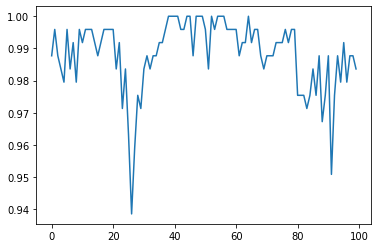

In [145]:
plt.plot(history.history['accuracy'])

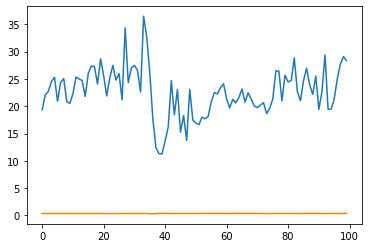

In [140]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])